In [1]:
import umap
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score

In [2]:
random_seed = 928579235

### Loading population and number of hospitals by tract to compute E2SFCA index

In [3]:
# 1. Population by tract
pop = pd.read_csv('data/rawData/acsdt5y2023-b01003.dat', sep='|', dtype=str)
pop.columns = ['GEO_ID','population','population_moe']
pop = pop[pop.GEO_ID.str.startswith('1400000US')]
pop['GEOID'] = pop.GEO_ID.str[-11:]
pop['population'] = pd.to_numeric(pop.population, errors='coerce').fillna(0)

In [4]:
# 2. Load & project hospitals
hosp = gpd.read_file('data/derivedData/hospitals/hospitals.shp')
# original CRS is EPSG:3857
hosp = hosp.to_crs(epsg=5070)

In [5]:
# 3. Load & project tracts
tracts = gpd.read_file('data/derivedData/tracts_all/tracts_all.shp')
tracts = tracts.set_crs(epsg=4269, allow_override=True).to_crs(epsg=5070)

In [6]:
# 4. Merge population into tracts
tracts = tracts.merge(pop[['GEOID','population']], on='GEOID', how='left')
tracts['population'] = tracts['population'].fillna(0)

In [7]:
# 5. Demand centroids & spatial index
demand = tracts.copy()
demand.geometry = tracts.geometry.centroid
dindex = demand.sindex

In [8]:
# 6. Clean hospital beds and build buffers
hosp['BEDS'] = pd.to_numeric(hosp['BEDS'], errors='coerce').fillna(0)
hosp = hosp[hosp.BEDS > 0].copy()
catch_m = 30000
hosp['buffer'] = hosp.geometry.buffer(catch_m)
hindex = hosp.sindex

In [9]:
# 7. Decay function
def decay(d): 
    return 1.0/(1.0 + d/1000.0)

In [10]:
# 8. Compute R_j using spatial index + intersects
R = []
for _, h in tqdm(hosp.iterrows()):
    idx = list(dindex.intersection(h.buffer.bounds))
    pts = demand.iloc[idx]
    pts = pts[pts.geometry.intersects(h.buffer)]
    pts['w'] = pts.geometry.distance(h.geometry).apply(decay)
    Pj = (pts.population * pts.w).sum()
    R.append(h.BEDS/Pj if Pj>0 else 0)
hosp['R'] = R

7883it [00:12, 628.20it/s] 


In [11]:
# 9. Compute A_i using spatial index + intersects
A = []
for _, t in tqdm(demand.iterrows()):
    idx = list(hindex.intersection(t.geometry.buffer(catch_m).bounds))
    nbrs = hosp.iloc[idx]
    nbrs = nbrs[nbrs.geometry.intersects(t.geometry.buffer(catch_m))]
    nbrs['wR'] = nbrs.R * nbrs.geometry.distance(t.geometry).apply(decay)
    A.append(nbrs.wR.sum())
demand['E2SFCA_index'] = A

85529it [00:51, 1664.18it/s]


In [12]:
# 10. Merge back & export
tracts = tracts.merge(demand[['GEOID','E2SFCA_index']], on='GEOID', how='left')
tracts.to_file('tracts_with_accessibility.gpkg', driver='GPKG')

In [13]:
print(tracts["E2SFCA_index"].describe())

count    85529.000000
mean         0.003470
std          0.002882
min          0.000000
25%          0.001739
50%          0.002919
75%          0.004344
max          0.111976
Name: E2SFCA_index, dtype: float64


### Combining E2FSCA data with socioeconomic and health burden data

In [14]:
# loading combined data with socio-economic and health burden estimates
combined = pd.read_csv('./data/derivedData/combined_df_0418.csv', dtype={'GEOID':str})

combined.columns

Index(['Median_Household_Income', 'Poverty_Population',
       'Unemployed_Population', 'SNAP_Recipients',
       'Total_Pop_Health_Insurance', 'Uninsured_Population',
       'Medicaid_Coverage', 'Medicare_Coverage', 'Private_Insurance_Coverage',
       'High_School_Graduates', 'Bachelor_Degree_Holders',
       'Less_than_High_School', 'Households_No_Vehicle',
       'Public_Transit_Usage', 'Renter_Occupied_Housing',
       'Rent_as_Income_Percentage', 'Overcrowded_Housing',
       'Elderly_Population', 'Children_Population', 'White_Population',
       'Black_Population', 'Households_No_Internet', 'state', 'county',
       'tract', 'clinic', 'hospital', 'nursing_home', 'social_facility',
       'ARTHRITIS_CrudePrev', 'BINGE_CrudePrev', 'CANCER_CrudePrev',
       'CASTHMA_CrudePrev', 'CHECKUP_CrudePrev', 'CHOLSCREEN_CrudePrev',
       'HPSA Score', 'Limited_English_Proficiency_Rate', 'No_Internet_Rate',
       'SLEEP_CrudePrev', 'latitude', 'longitude', 'Geography', 'StateAbbr',
       

In [15]:
#cols_to_drop = list(combined.select_dtypes(include=['object', 'category']).columns)
#cols_to_drop.remove("GEOID")

#print(cols_to_drop)
#combined = combined.drop(columns=cols_to_drop 
#                                 + ["latitude", "longitude", "state", "county", "tract"])

#combined.columns

In [16]:
# Merge with tracts GeoDataFrame
tracts = tracts.merge(
    combined, #[['GEOID','pct_uninsured','pct_no_vehicle']],
    on='GEOID', how='left'
)

In [17]:
len(tracts)

85529

In [18]:
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry', 'population', 'E2SFCA_index',
       'Median_Household_Income', 'Poverty_Population',
       'Unemployed_Population', 'SNAP_Recipients',
       'Total_Pop_Health_Insurance', 'Uninsured_Population',
       'Medicaid_Coverage', 'Medicare_Coverage', 'Private_Insurance_Coverage',
       'High_School_Graduates', 'Bachelor_Degree_Holders',
       'Less_than_High_School', 'Households_No_Vehicle',
       'Public_Transit_Usage', 'Renter_Occupied_Housing',
       'Rent_as_Income_Percentage', 'Overcrowded_Housing',
       'Elderly_Population', 'Children_Population', 'White_Population',
       'Black_Population', 'Households_No_Internet', 'state', 'county',
       'tract', 'clinic', 'hospital', 'nursing_home', 'social_facility',
       'ARTHRITIS_CrudePrev', 'BINGE_CrudePrev', 'CANCER_CrudePrev',
       'CASTHMA_CrudePrev', 'CHEC

### Scaling features

In [19]:
# 1. Specify features to standardize
features = [
    'E2SFCA_index',  
    #'Median_Household_Income',
    'Uninsured_Population',             
    'Households_No_Vehicle',            
    'Limited_English_Proficiency_Rate', 
    'No_Internet_Rate',                 
    'Overcrowded_Housing',              
    'Rent_as_Income_Percentage',   
    #'HPSA Score',
    #'Poverty_Population',
    #'Bachelor_Degree_Holders',
    #'Black_Population',
    #'CANCER_CrudePrev',
    #'CASTHMA_CrudePrev'
]

# 2. Drop any tracts with NaNs in these features
tracts_clean = tracts.dropna(subset=features).copy()
tracts_clean = tracts_clean[
    (tracts_clean['Uninsured_Population'] != 0) |
    (tracts_clean['Limited_English_Proficiency_Rate'] != 100) |
    (tracts_clean['Rent_as_Income_Percentage'] != 51)
]

# 3. Extract and scale
scaler   = StandardScaler()  
X        = tracts_clean[features].astype(float)
X_scaled = scaler.fit_transform(X)

# 4. Store back into the cleaned DataFrame (suffix '_z')
for i, col in enumerate(features):
    tracts_clean[f'{col}_z'] = X_scaled[:, i]

# 5. (Optional) View means & variances post-scaling
tracts_clean[[f'{c}_z' for c in features]].describe() #agg(['mean','std'])

,E2SFCA_index_z,Uninsured_Population_z,Households_No_Vehicle_z,Limited_English_Proficiency_Rate_z,No_Internet_Rate_z,Overcrowded_Housing_z,Rent_as_Income_Percentage_z
count,1.614800e+04,16148.000000,1.614800e+04,1.614800e+04,1.614800e+04,1.614800e+04,1.614800e+04
mean,-1.196852e-16,0.000000,-4.224183e-17,-6.336274e-16,-7.568327e-17,2.816122e-17,-3.916169e-16
std,1.000031e+00,1.000031,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.618684e+00,-0.611433,-5.134503e-01,-8.159694e+00,-1.282244e+00,-2.922628e-01,-2.816186e+00
25%,-5.817760e-01,-0.611433,-4.355550e-01,-5.606612e-01,-7.426635e-01,-2.922628e-01,-7.049754e-01
50%,-2.412237e-01,-0.375046,-2.575087e-01,1.062502e-01,-2.348234e-01,-2.922628e-01,-1.740862e-01
75%,2.737282e-01,0.154012,6.520032e-02,6.886235e-01,5.007512e-01,-2.922628e-01,5.419969e-01
max,1.568197e+01,14.145897,1.906052e+01,1.947301e+00,6.660164e+00,2.268692e+01,2.369243e+00


In [20]:
#for n, i in enumerate(features):
#    plt.hist(tracts_clean[features].iloc[:, n], bins="fd")
#    plt.title(i)
#    plt.show()

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_94422/772227328.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(pca_components[:, 0], pca_components[:, 1],
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_94422/772227328.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(umap_components[:, 0], umap_components[:, 1],


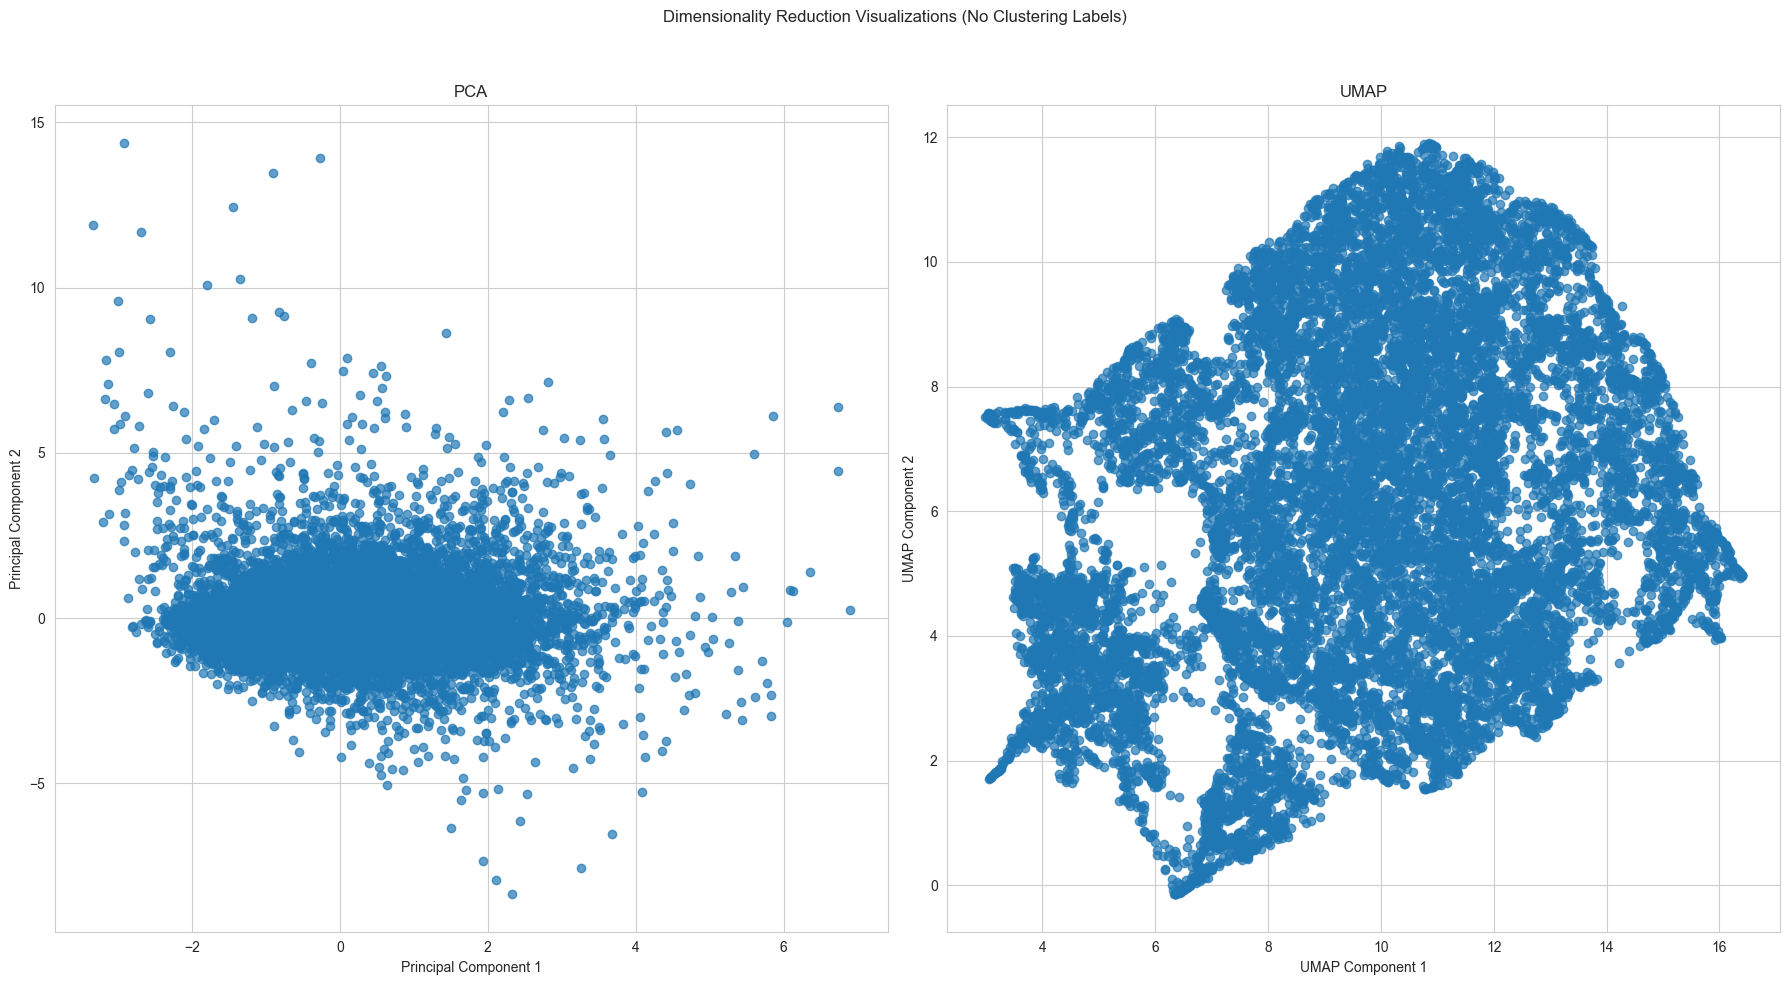

In [21]:
def visualize_data_structure(features_scaled, random_state=random_seed):
    """
    Generate 2D visualizations using PCA and UMAP to explore 
    the intrinsic structure of the data without using clustering labels.
    
    Parameters:
        features_scaled: Scaled feature matrix (numpy array or pandas DataFrame)
        random_state: Seed for reproducibility
    """
    # PCA: Linear reduction capturing maximum variance directions.
    pca = PCA(n_components=2, random_state=random_state)
    pca_components = pca.fit_transform(features_scaled)
    
    # UMAP: Non-linear method balancing local structure with global geometry.
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    umap_components = reducer.fit_transform(features_scaled)

    # Set up subplots: one for each dimensionality reduction technique.
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # PCA Scatter Plot
    axes[0].scatter(pca_components[:, 0], pca_components[:, 1], 
                    cmap='viridis', alpha=0.7)
    axes[0].set_title("PCA")
    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")
    
    # UMAP Scatter Plot
    axes[1].scatter(umap_components[:, 0], umap_components[:, 1],
                    cmap='viridis', alpha=0.7)
    axes[1].set_title("UMAP")
    axes[1].set_xlabel("UMAP Component 1")
    axes[1].set_ylabel("UMAP Component 2")
    
    plt.suptitle("Dimensionality Reduction Visualizations (No Clustering Labels)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
visualize_data_structure(X_scaled)

#### Computing the "Access Deficit Index"

In [22]:
# 1. Run PCA on X_scaled (shape = [n_clean, n_features])
pca = PCA(n_components=0.80)
pcs = pca.fit_transform(X_scaled)

# 2. Attach the first PC back to tracts_clean
tracts_clean['Access_Deficit_Index'] = pcs[:, 0]

# 3. Inspect variance explained
print("Explained variance ratios:", pca.explained_variance_ratio_)

# 4. Merge the new index back onto the full tracts GeoDataFrame
tracts = tracts.merge(
    tracts_clean[['GEOID', 'Access_Deficit_Index']],
    on='GEOID',
    how='left'
)

Explained variance ratios: [0.20676895 0.18161147 0.16443511 0.13059145 0.12020457]


### Clustering and visualization

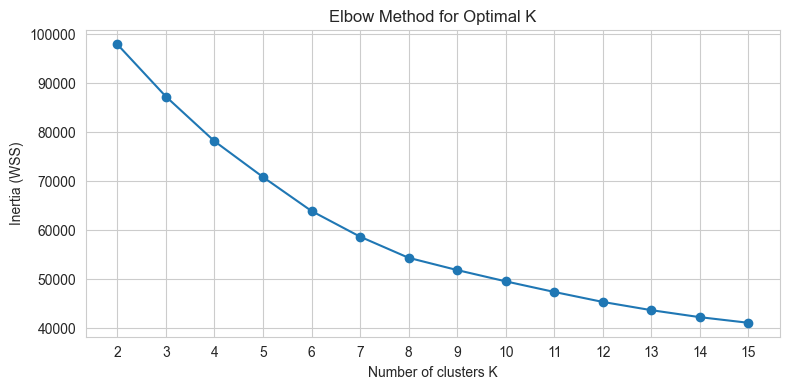

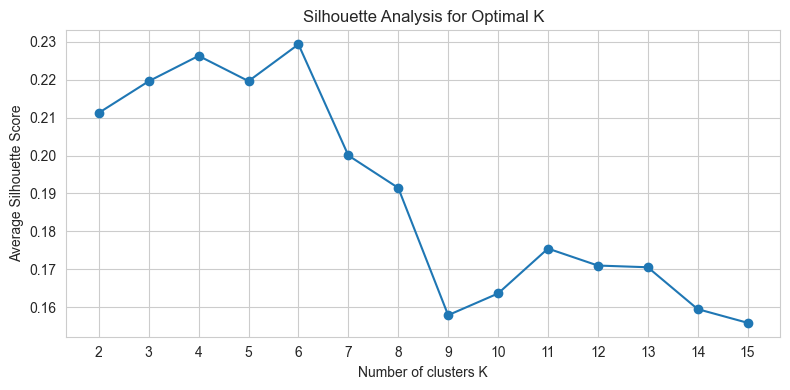

In [23]:
ks = range(2, 16)  # test K = 2 through 15
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=random_seed, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# 1. Elbow plot
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Method for Optimal K')
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Silhouette plot
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, '-o')
plt.xlabel('Number of clusters K')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

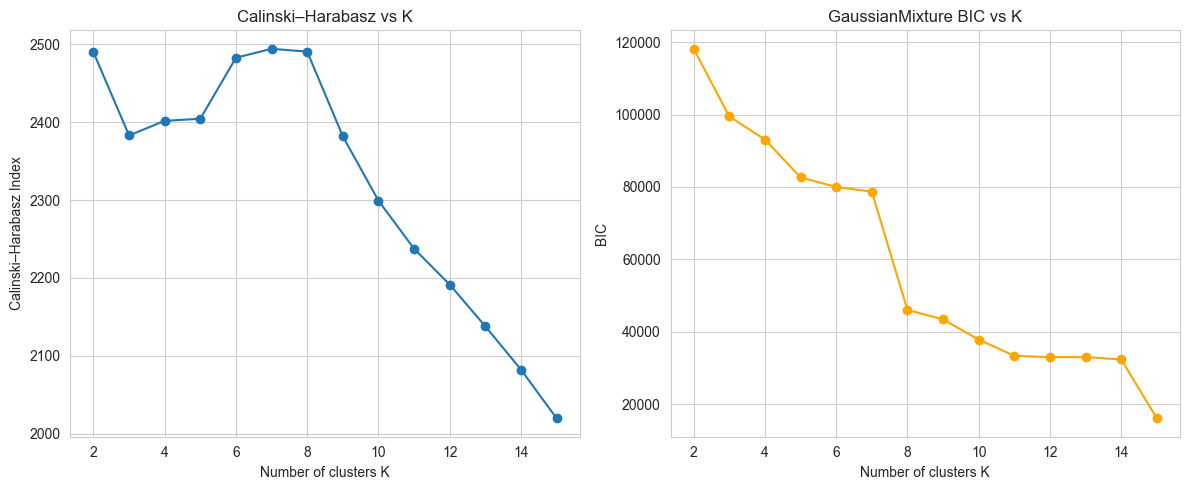

Optimal K by Calinski–Harabasz: 7
Optimal K by BIC: 15


In [24]:
# Range of cluster counts to test
Ks = range(2, 16)

ch_scores = []
bic_scores = []

for k in Ks:
    # 1) Calinski–Harabasz via KMeans
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=random_seed)
    labels = km.fit_predict(X_scaled)
    ch = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(ch)
    
    # 2) BIC via GaussianMixture
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_seed)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    bic_scores.append(bic)

# Plot CH index
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Ks, ch_scores, '-o')
plt.xlabel('Number of clusters K')
plt.ylabel('Calinski–Harabasz Index')
plt.title('Calinski–Harabasz vs K')
plt.grid(True)

# Plot BIC
plt.subplot(1,2,2)
plt.plot(Ks, bic_scores, '-o', color='orange')
plt.xlabel('Number of clusters K')
plt.ylabel('BIC')
plt.title('GaussianMixture BIC vs K')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the optimal Ks
best_ch = Ks[np.argmax(ch_scores)]
best_bic = Ks[np.argmin(bic_scores)]
print(f"Optimal K by Calinski–Harabasz: {best_ch}")
print(f"Optimal K by BIC: {best_bic}")

In [25]:
# K-Means clustering
kmeans = KMeans(n_clusters=best_ch, init='k-means++', random_state=random_seed)
labels = kmeans.fit_predict(X_scaled)

# Compute UMAP embedding
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_seed)
embedding = reducer.fit_transform(X_scaled)

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


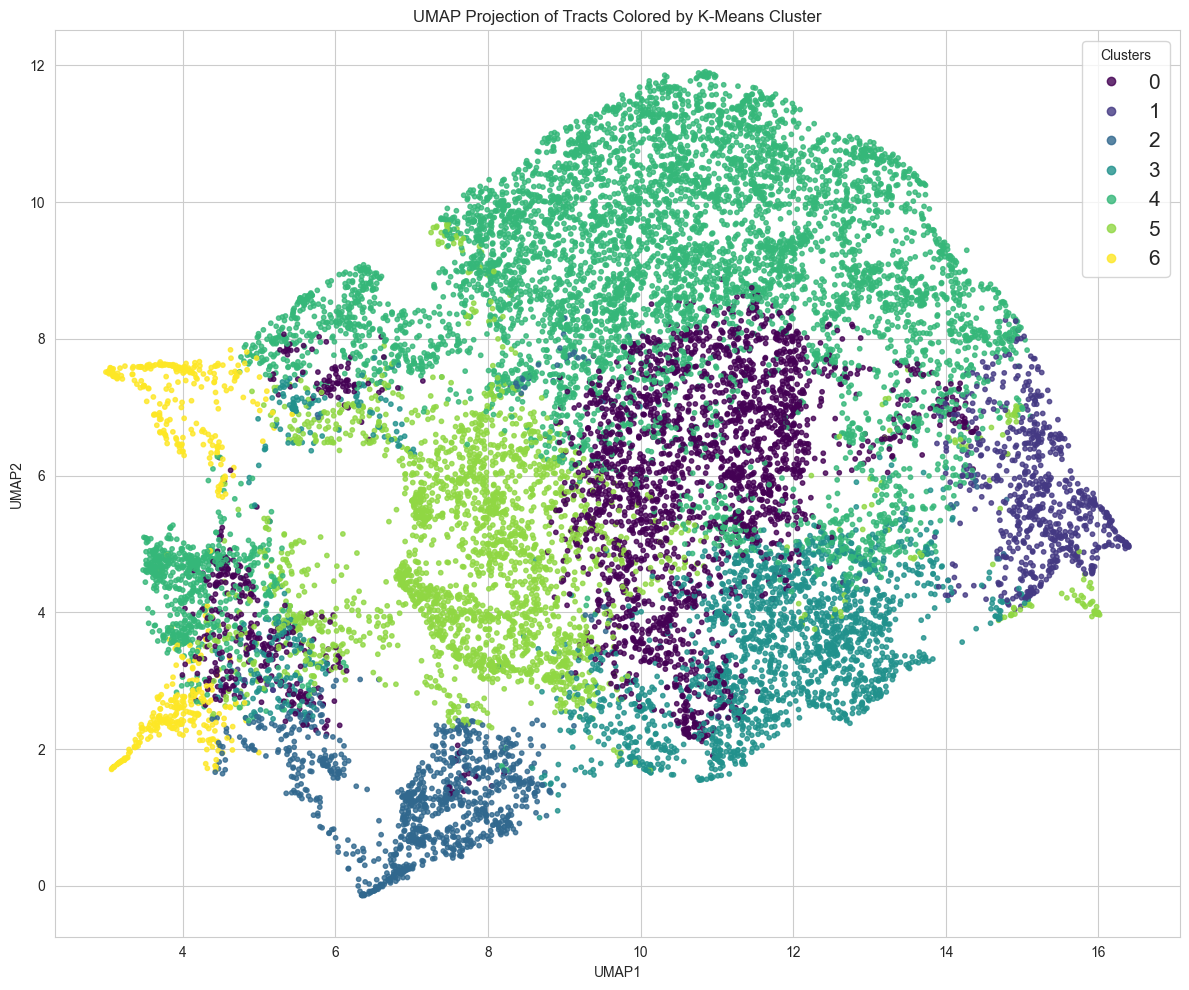

In [26]:
# UMAP with cluster colors
plt.figure(figsize=(12,10))
scatter = plt.scatter(
    embedding[:,0], embedding[:,1],
    c=labels, cmap='viridis', s=10, alpha=0.8
)
plt.legend(*scatter.legend_elements(), title="Clusters", fontsize=15)
plt.title("UMAP Projection of Tracts Colored by K-Means Cluster")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

In [27]:
# 1. Initialize GMM with 7 components
gmm = GaussianMixture(
    n_components=best_ch,         # number of clusters
    covariance_type='full', # each component has its own covariance
    random_state=random_seed,        # for reproducibility
    n_init=5                # number of EM restarts
)

# 2. Fit to your scaled data and predict cluster labels
clusters_gmm = gmm.fit_predict(X_scaled)      # shape (n_samples,)

# 3. Attach labels back to your GeoDataFrame
tracts_clean['GMM_cluster'] = clusters_gmm

# 4. (Optional) Extract posterior probabilities for each component
probs = gmm.predict_proba(X_scaled)           # shape (n_samples, 7)

# 5. Brief summary
print("Unique GMM cluster labels:", np.unique(clusters_gmm))
print("GMM converged in iterations:", gmm.n_iter_)

Unique GMM cluster labels: [0 1 2 3 4 5 6]
GMM converged in iterations: 35


/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


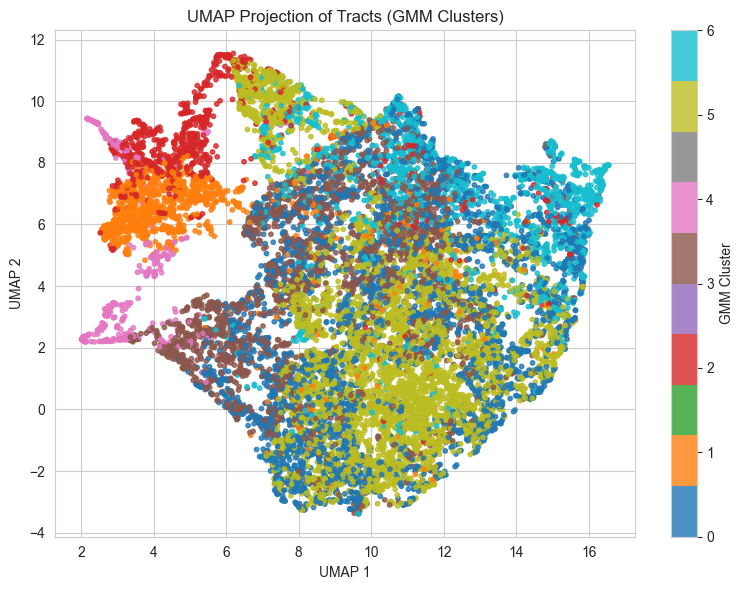

In [28]:
# 1. Compute the 2D UMAP embedding
reducer   = umap.UMAP(n_neighbors=7, min_dist=0.1, random_state=random_seed)
embedding = reducer.fit_transform(X_scaled)             # (n_samples, 2)

# 2. Plot the embedding colored by GMM cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding[:, 0], embedding[:, 1],
    c=clusters_gmm, cmap='tab10', s=10, alpha=0.8
)
plt.colorbar(scatter, label='GMM Cluster')            # 
plt.title('UMAP Projection of Tracts (GMM Clusters)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()